In [203]:
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 


%matplotlib inline

In [170]:
# function to convert datetime object to 4 - for force ONLY
def datetime(df, col_as_str):
    yearmonthday = df[col_as_str].astype(str).str.split(" ")
    ymd = yearmonthday.apply(lambda x: x[0]).str.split("/")
    year = ymd.apply(lambda x: x[2])
    month = ymd.apply(lambda x: x[0])
    day = ymd.apply(lambda x: x[1])
    time = ymd = yearmonthday.apply(lambda x: x[1]+x[2]).astype(str)
    df["year"] = year
    df["month"] = month
    df["day"] = day
    df["time"] = time
    # apply(lambda x: pd.to_datetime(x, format="%H%M"))
    return df

In [190]:
force = pd.read_csv("data/Use_Of_Force.csv")

In [191]:
force = datetime(force,"Occured_date_time" )
foo = pd.to_datetime( force.Occured_date_time )
epoch_second = foo.map(lambda x:x.value/1e9)
force["epoch"] = epoch_second

force["day_of_week"] = foo.dt.dayofweek

In [194]:
# Function to convert the date format 
def convert24(str1): 
    
    
      
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[-2:] == "AM" and str1[:2] == "12": 
        return (int("00" + str1[3:5])/100)
          
    # remove the AM     
    elif str1[-2:] == "AM": 
        return (int(str1[:2] + str1[3:5])/100)
      
    # Checking if last two elements of time 
    # is PM and first two elements are 12    
    elif str1[-2:] == "PM" and str1[:2] == "12": 
        return (int(str1[:2] + str1[3:5])/100)
          
    else: 
          
        # add 12 to hours and remove PM 
        return (int(str(int(str1[:2]) + 12) + str1[3:5])/100)

In [195]:
force["time"] = force["time"].apply(lambda x: convert24(x))


In [197]:
force.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9838 entries, 0 to 9837
Data columns (total 17 columns):
ID                   9838 non-null object
Incident_Num         9838 non-null int64
Incident_Type        9838 non-null object
Occured_date_time    9838 non-null object
Precinct             9838 non-null object
Sector               9838 non-null object
Beat                 9838 non-null object
Officer_ID           9838 non-null int64
Subject_ID           9838 non-null int64
Subject_Race         9838 non-null object
Subject_Gender       9838 non-null object
year                 9838 non-null object
month                9838 non-null object
day                  9838 non-null object
time                 9838 non-null float64
epoch                9838 non-null float64
day_of_week          9838 non-null int64
dtypes: float64(2), int64(4), object(11)
memory usage: 1.3+ MB


In [33]:
len(force.Incident_Type.value_counts()), len(force.year.value_counts()), len(force.month.value_counts()), len(force)


(4, 6, 12, 9838)

In [34]:
force.Incident_Type.value_counts()

Level 1 - Use of Force    7474
Level 2 - Use of Force    2185
Level 3 - Use of Force     105
Level 3 - OIS               74
Name: Incident_Type, dtype: int64

In [41]:
force1 = force[force["Incident_Type"] == "Level 1 - Use of Force"]
force2 = force[force["Incident_Type"] == "Level 2 - Use of Force"]
force3 = force[force["Incident_Type"] == "Level 3 - Use of Force"]
forceOIS = force[force["Incident_Type"] == "Level 3 - OIS"]

In [54]:
f1b = force1.Beat.value_counts()
f2b = force2.Beat.value_counts()
f3b = force3.Beat.value_counts()
fOISb = forceOIS.Beat.value_counts()
force_beats = pd.DataFrame({"force1":f1b, "force2":f2b, "force3": f3b,"forceOIS": fOISb})

In [291]:
force_beats.fillna(0, inplace=True)


In [292]:
#force.groupby("Beat")["Subject_Race"].value_counts()

In [154]:
times = force["time"].value_counts(sort=False, bins=12)

In [201]:
X = force[["month", "day", "time", "day_of_week","Subject_Race", "Subject_Gender", "Precinct", "Sector", "Beat"]]
y = force["Incident_Type"



In [204]:
# makes more sense to use all the data - bc time of year could change the outcome as well

enc = OneHotEncoder()

In [206]:
enc.fit(X)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [209]:
XT = enc.transform(X)

In [217]:
type(XT)

scipy.sparse.csr.csr_matrix

In [218]:
data = XT.data

In [234]:
XT.shape, y.shape

((9838, 1469), (9838,))

In [235]:
X_train, X_test, y_train, y_test = train_test_split(XT, y, test_size=0.2, random_state=659)

In [236]:
rdf = RandomForestClassifier(oob_score=True, random_state=659)

In [239]:
rdf.fit(X_train, y_train)

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=659, verbose=0,
                       warm_start=False)

In [241]:
yhat = rdf.predict(X_test)

In [242]:
rdf.score(X_test, y_test)

0.8516260162601627

In [260]:
r = rdf.feature_importances_

In [261]:
np.argmax(r)

1384

In [290]:
'''X = pd.get_dummies(data = X, 
                     columns=["Subject_Gender", "Subject_Race", 
                             "Precinct", "Sector", "Beat"], 
                     prefix=["Subject_Gender", "Subject_Race", 
                             "Precinct", "Sector", "Beat"])'''

'X = pd.get_dummies(data = X, \n                     columns=["Subject_Gender", "Subject_Race", \n                             "Precinct", "Sector", "Beat"], \n                     prefix=["Subject_Gender", "Subject_Race", \n                             "Precinct", "Sector", "Beat"])'

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=659)

In [277]:
rf = RandomForestClassifier(oob_score=True, random_state=659)

In [279]:
rf.fit(X_train, y_train)

/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/sarahburgart/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=659, verbose=0,
                       warm_start=False)

In [273]:
rf.score(X_test, y_test)

0.8648373983739838

In [281]:
# most important features
indices = np.argsort(rf.feature_importances_)
big = indices[-10:]
cols = X.columns
cols[big]

Index(['Subject_Gender_Female', 'Subject_Race_Hispanic or Latino',
       'Subject_Gender_Male', 'Subject_Race_Not Specified',
       'Subject_Race_Black or African American', 'Subject_Race_White',
       'day_of_week', 'month', 'day', 'time'],
      dtype='object')

In [285]:
sorted(rf.feature_importances_)[-10:]

[0.009074258700210088,
 0.01069906746826961,
 0.015328404396293705,
 0.01665047999728756,
 0.02045204033510796,
 0.023434961506206085,
 0.11285092024719348,
 0.13272988780083372,
 0.17100353196302862,
 0.25109350909943956]

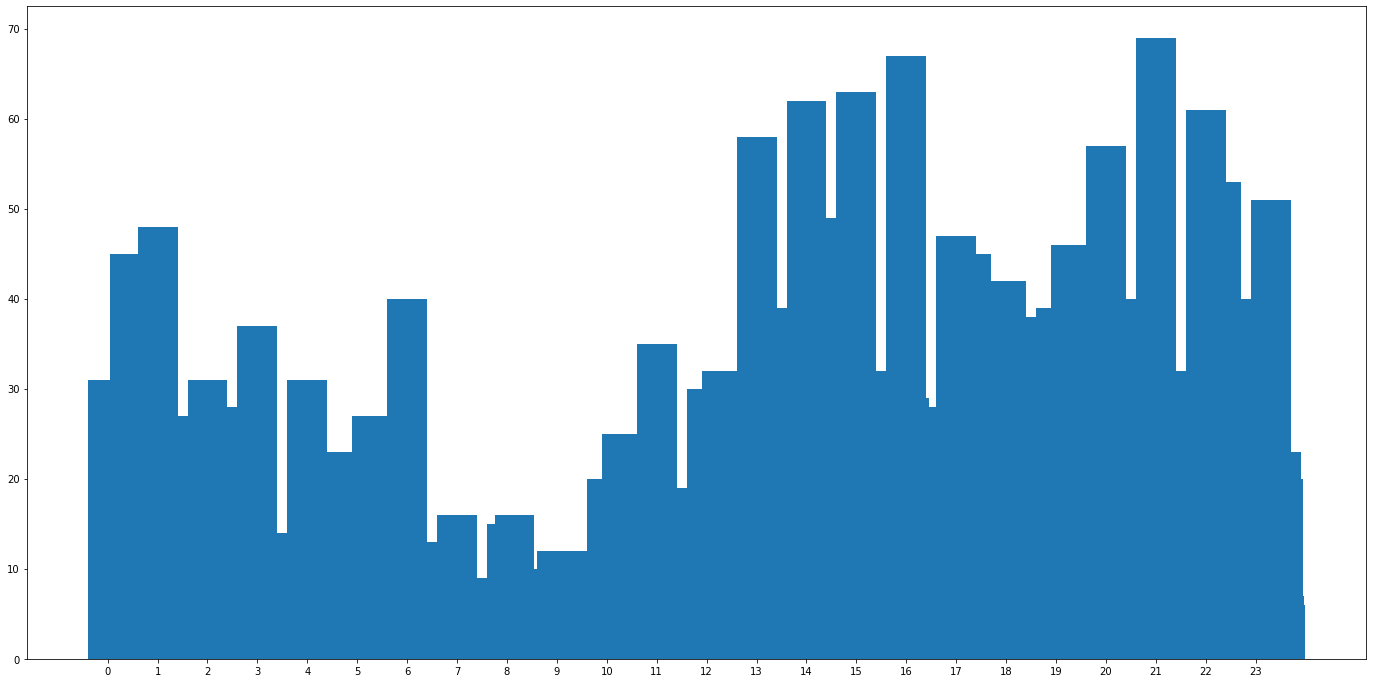

In [305]:
t = X.time.value_counts()

fig, axs = plt.subplots(1,1,figsize=(24,12))
axs.bar(t.index, t);
axs.set_xticks(np.arange(24));

In [313]:
ts = t.sort_index()

In [314]:
len(ts)

1328

In [326]:
tsc = pd.cut(ts, 8, retbins=True)

In [328]:
# # Group the data by the index's hour value, then aggregate by the average
series.groupby(series.index.hour).mean()

# or round down

NameError: name 'series' is not defined